## Self driving car model

In [1]:
!git clone https://github.com/tzudir/Self_driving

Cloning into 'Self_driving'...
remote: Enumerating objects: 138278, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 138278 (delta 0), reused 1 (delta 0), pack-reused 138276
Receiving objects: 100% (138278/138278), 1.45 GiB | 26.26 MiB/s, done.
Resolving deltas: 100% (77/77), done.
Updating files: 100% (112595/112595), done.


In [23]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as keras
import tensorflow as tf
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Lambda, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import ntpath

In [5]:
datadir = '/content/Self_driving/drive2'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)

In [6]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,Desktop\track2data\IMG\center_2019_04_02_18_05_37_641.jpg,Desktop\track2data\IMG\left_2019_04_02_18_05_37_641.jpg,Desktop\track2data\IMG\right_2019_04_02_18_05_37_641.jpg,0.0,0.0,0.0,0.000275
1,Desktop\track2data\IMG\center_2019_04_02_18_05_37_712.jpg,Desktop\track2data\IMG\left_2019_04_02_18_05_37_712.jpg,Desktop\track2data\IMG\right_2019_04_02_18_05_37_712.jpg,0.0,0.0,0.0,0.000280
2,Desktop\track2data\IMG\center_2019_04_02_18_05_37_783.jpg,Desktop\track2data\IMG\left_2019_04_02_18_05_37_783.jpg,Desktop\track2data\IMG\right_2019_04_02_18_05_37_783.jpg,0.0,0.0,0.0,0.000277
3,Desktop\track2data\IMG\center_2019_04_02_18_05_37_853.jpg,Desktop\track2data\IMG\left_2019_04_02_18_05_37_853.jpg,Desktop\track2data\IMG\right_2019_04_02_18_05_37_853.jpg,0.0,0.0,0.0,0.000046
4,Desktop\track2data\IMG\center_2019_04_02_18_05_37_922.jpg,Desktop\track2data\IMG\left_2019_04_02_18_05_37_922.jpg,Desktop\track2data\IMG\right_2019_04_02_18_05_37_922.jpg,0.0,0.0,0.0,0.000060


In [7]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [8]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_04_02_18_05_37_641.jpg,left_2019_04_02_18_05_37_641.jpg,right_2019_04_02_18_05_37_641.jpg,0.0,0.0,0.0,0.000275
1,center_2019_04_02_18_05_37_712.jpg,left_2019_04_02_18_05_37_712.jpg,right_2019_04_02_18_05_37_712.jpg,0.0,0.0,0.0,0.000280
2,center_2019_04_02_18_05_37_783.jpg,left_2019_04_02_18_05_37_783.jpg,right_2019_04_02_18_05_37_783.jpg,0.0,0.0,0.0,0.000277
3,center_2019_04_02_18_05_37_853.jpg,left_2019_04_02_18_05_37_853.jpg,right_2019_04_02_18_05_37_853.jpg,0.0,0.0,0.0,0.000046
4,center_2019_04_02_18_05_37_922.jpg,left_2019_04_02_18_05_37_922.jpg,right_2019_04_02_18_05_37_922.jpg,0.0,0.0,0.0,0.000060


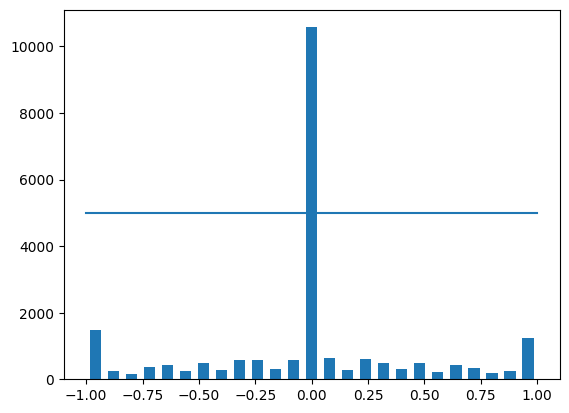

In [10]:
num_bins = 25
samples_per_bin = 5000
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [11]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

removed:  5575
remaining:  16253


In [12]:
hist, bins = np.histogram(data['steering'], (num_bins))

In [13]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [14]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [15]:
image_paths

array(['/content/Self_driving/drive2/IMG/center_2019_04_02_18_05_37_712.jpg',
       '/content/Self_driving/drive2/IMG/left_2019_04_02_18_05_37_712.jpg',
       '/content/Self_driving/drive2/IMG/right_2019_04_02_18_05_37_712.jpg',
       ...,
       '/content/Self_driving/drive2/IMG/center_2019_04_02_18_31_04_870.jpg',
       '/content/Self_driving/drive2/IMG/left_2019_04_02_18_31_04_870.jpg',
       '/content/Self_driving/drive2/IMG/right_2019_04_02_18_31_04_870.jpg'],
      dtype='<U67')

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state = 6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 39007
Valid Samples: 9752


Text(0.5, 1.0, 'Validation set')

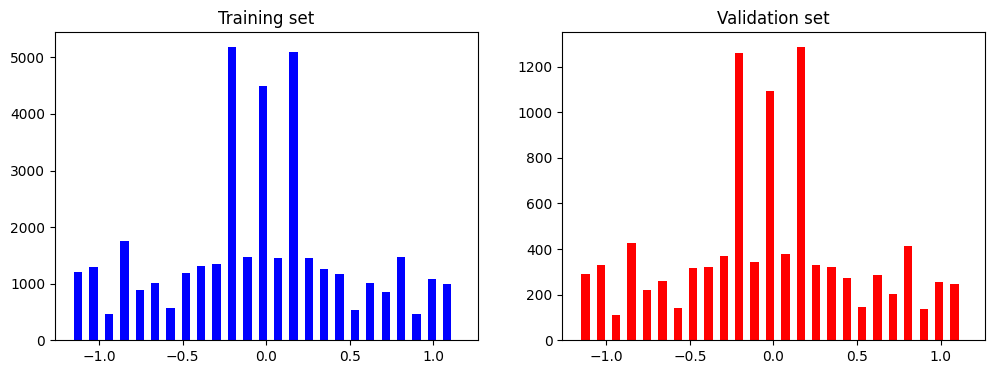

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [18]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle


In [19]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [20]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [21]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [ ]:
# def nvidia_model():
#   model = Sequential()
#   model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
#   model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
#   model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
#   model.add(Conv2D(64, (5, 5), activation='elu'))


#   model.add(Flatten())

#   model.add(Dense(100, activation = 'elu'))

#   model.add(Dense(50, activation = 'elu'))

#   model.add(Dense(10, activation = 'elu'))


#   model.add(Dense(1))

#   optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
#   model.compile(loss='mse', optimizer=optimizer)
#   return model

# model = nvidia_model()
# print(model.summary())

In [24]:
def get_model():
    model = Sequential([
        Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu', input_shape=(66, 200, 3)),
        BatchNormalization(axis=1),
        Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
        BatchNormalization(axis=1),
        Flatten(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(50, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])

    return model

model = get_model()
initial_learning_rate = 0.001
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 batch_normalization (Batch  (None, 31, 98, 24)        124       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 47, 36)        56        
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 batch_normalization_2 (Bat  (None, 5, 22, 48)         2

In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

<ipython-input-21-c6c3380b9281>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/10
300/300 [==============================] - 147s 467ms/step - loss: 0.5338 - val_loss: 0.3063
Epoch 2/10
300/300 [==============================] - 123s 412ms/step - loss: 0.1888 - val_loss: 0.2741
Epoch 3/10
300/300 [==============================] - 137s 457ms/step - loss: 0.1648 - val_loss: 0.2252
Epoch 4/10
300/300 [==============================] - 123s 412ms/step - loss: 0.1653 - val_loss: 0.2334
Epoch 5/10
300/300 [==============================] - 124s 416ms/step - loss: 0.1481 - val_loss: 0.2016
Epoch 6/10
300/300 [==============================] - 167s 557ms/step - loss: 0.1405 - val_loss: 0.1607
Epoch 7/10
300/300 [==============================] - 120s 403ms/step - loss: 0.1363 - val_loss: 0.1497
Epoch 8/10
300/300 [==============================] - 120s 401ms/step - loss: 0.1311 - val_loss: 0.1197
Epoch 9/10
300/300 [==============================] - 121s 403ms/step - loss: 0.1288 - val_loss: 0.1260
Epoch 10/10
300/300 [==============================] - 119s 398m

Text(0.5, 0, 'Epoch')

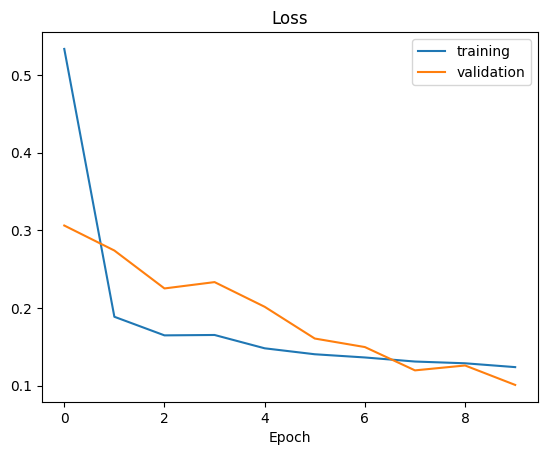

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model7.h5')
from google.colab import files
files.download('model7.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>